# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

#### - Import package

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import json
import datetime

import itertools

# plot libraries 
import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
print('All Packages Import')

All Packages Import


#### Datasets

In [2]:
# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)
print("Loaded")

Loaded


### - Portfolio datasets 
Lets start with exploring the portfolio dataset:

In [3]:
print(portfolio.shape)
portfolio.head()

(10, 6)


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [5]:
#lets count offer types
portfolio['offer_type'].value_counts()

discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64

In [6]:
#describe
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


**portfolio datasets cleaning steps:**

    - channels contain a list of values. 

    - rename id into offer_id.
     
    - handle the categorical offer_type.
    
    - Normalizing 'difficulty'  and 'reward' features using the MinMaxScaler.
    
    - Preprocessing 'offer_id' Feature
    
    - Preprocessing 'offer_type' Feature

### - Profile datasets 
Lets start with exploring the Profile dataset:

In [7]:
print(profile.shape)
profile.head()

(17000, 5)


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [8]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [9]:
# check for any duplicated values
print("duplicated :",profile.duplicated().sum())
#find any NaN values
print("NaN Values: \n",profile.isna().sum())

duplicated : 0
NaN Values: 
 gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64


In [10]:
#describe
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [11]:
#lets count age types
profile['age'].value_counts()

118    2175
58      408
53      372
51      363
54      359
       ... 
100      12
96        8
98        5
99        5
101       5
Name: age, Length: 85, dtype: int64

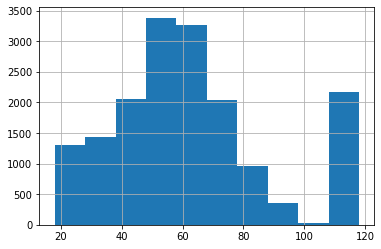

In [12]:
profile['age'].hist()

so from the above we notice that even when we remove age values of 118, we still have a maximum value of 101 for the age so to check if this should be considered an outlier values.

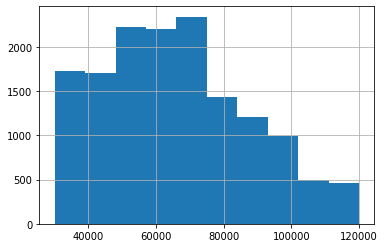

In [13]:
profile['income'].hist()

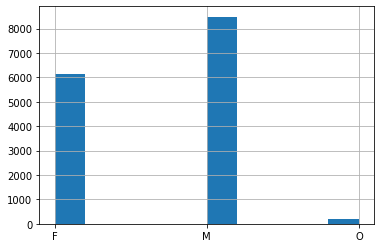

In [14]:
profile['gender'].hist()

In [15]:
#lets count gender types
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

**Profile Datasets Data Cleaning**

- Preprocessing 'id' Feature:
    - Rename 'id' column name to 'customer_id'.
    - Re-arrange the columns to have 'customer_id' column the first column in dataset.
    - Replace the customer_id string values  with easiest numerical values.
    
- Preprocessing 'age' Feature:
    - Replace age = 118 by NaN value.
    - Remove customers (drop rows) with no 'age', 'gender' and 'income'.
    - Change the datatype of 'age' and 'income' columns to 'int'.
    - Create a new column 'age_group' that includes the age_group to which each customer belongs
    - Replace the 'age_group' categorical label by a corresponding numerical label, as follows: 
        - 1 : teenager
        - 2 : young-adult
        - 3 : adult
        - 4 : elderly
        
- Preprocessing 'income' Feature:
    - Create a new column 'income_range' that includes the income-range to which the customer's income belongs.
    - Replace the 'income_range' categorical label by a corresponding numerical label, as follows: 
        - 1 : average (30,000 - 60,000)
        - 2 : above-average (60,0001 - 90,000)
        - 3 : high (more than 90,000)

- Preprocessing 'gender' Feature:
    - Replace the 'gender' categorical labels with coressponding numerical label, as follows:
        - 1 : F (Female)
        - 2 : M (Male)
        - 3 : O

- Preprocessing 'became_member_on' Feature:
    - Change the datatype of 'became_member_on' column from int to date and put it in the appropriate format in order to have a readable date format  that can be analyzed easily if requiered.
    - Add a new column 'start_year', that will present the year at which the customer become a member, to the existing dataset (for further analysis).
    - Add a new column 'membership_days' ,that will present the number of days since the customer became a member, to the existing dataset (for further analysis).
    - Create a new column 'member_type' representing the type of the member: new, regular or loyal depending on the number of his 'membership_days'.
    - Replace the 'member_type' categorical label by a corresponding numerical label, as follows: 
        - 1 : new (memebr since 1000 days or less)
        - 2 : regular (1001 - 1,600 days of membership)
        - 3 : loyal (more than 1,600 days of membership)

- Drop 'age','income', 'became_member_on' and 'membership_days' columns, since they are no longer needed.

### - Transcript datasets 
Lets start with exploring the Transcript dataset:

In [16]:
print(transcript.shape)
transcript.head()

(306534, 4)


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [17]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [18]:
#find any NaN values
transcript.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [19]:
#describe
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [20]:
#lets count event types
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

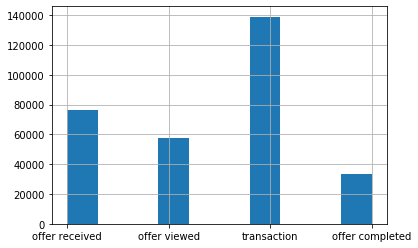

In [21]:
transcript['event'].hist()

**Transcript Datasets Data Cleaning**

- Rename 'time' column to 'time_h' representing that the unit of measurment is 'hours'.
- Preprocess 'person' Feature:
    - Rename 'person' column to 'customer_id'.
    - Replace the categorical values in 'customer_id' column by the newly initiated numerical values corresponding with each customer id, which resulted from the previous. 

- Preprocess 'value' Feature:
    - Extract each key that exists in the 'value' column to a seperate column than dropping the 'value' column.
    - Fill all the NaNs in the 'offer_id' column with 'N/A' values (i.e. Not Applicable).
    - Drop the 'value' column since it is no longer needed.
       
- Preprocess 'event' Feature:
    - Excluding all events of 'transaction' or 'offer received' from our clean_transcript dataset.
    - Replace the 'event' categorical labels with coressponding numerical label, as follows:
        - 1 : offer completed
        - 2 : offer viewed
        
- Preprocess 'offer_id' Feature:
    - Replace the categorical values in the 'offer_id' column by the corresponding numerical values used initiated during 
  

## - Data Cleaning And Feature Engineering

### - Portfolio datasets cleaning


In [22]:
clean_portfolio = portfolio.copy() 

In [23]:
clean_portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


  - Handle list of values in channels append a new list of columns correponding to all the existing channel and set 1 when this exist in the row


In [24]:
channels_unique = list(set(itertools.chain(*clean_portfolio.channels.tolist())))
print(channels_unique)

for channel in channels_unique:
    clean_portfolio[channel] = clean_portfolio.channels.apply(lambda x:1 if channel in x else 0 )

# drop the channels columns 
clean_portfolio.drop(columns=['channels'], inplace=True)
clean_portfolio.head()

['web', 'mobile', 'email', 'social']


,reward,difficulty,duration,offer_type,id,web,mobile,email,social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,1,0


 - Rename id into offer_id.

In [25]:
# rename the id to offer id column
clean_portfolio.rename(columns={'id':'offer_id'}, inplace=True)
clean_portfolio.head()

,reward,difficulty,duration,offer_type,offer_id,web,mobile,email,social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,1,0


  - handle the categorical offer_type.

In [26]:
clean_portfolio['offer_type'] = clean_portfolio['offer_type'].astype('category')
clean_portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   reward      10 non-null     int64   
 1   difficulty  10 non-null     int64   
 2   duration    10 non-null     int64   
 3   offer_type  10 non-null     category
 4   offer_id    10 non-null     object  
 5   web         10 non-null     int64   
 6   mobile      10 non-null     int64   
 7   email       10 non-null     int64   
 8   social      10 non-null     int64   
dtypes: category(1), int64(7), object(1)
memory usage: 882.0+ bytes


 - Normalizing 'difficulty'  and 'reward' features using the MinMaxScaler.

In [27]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['difficulty','reward']

#features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
clean_portfolio[numerical] = scaler.fit_transform(clean_portfolio[numerical])

# Show an example of a record with scaling applied
clean_portfolio.head()

,reward,difficulty,duration,offer_type,offer_id,web,mobile,email,social
0,1.0,0.50,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,1.0,0.50,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0.0,0.00,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,0.5,0.25,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,0.5,1.00,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,1,0


  - Preprocessing 'offer_id' Feature

In [28]:
clean_portfolio['offer_id'].value_counts()

f19421c1d4aa40978ebb69ca19b0e20d    1
ae264e3637204a6fb9bb56bc8210ddfd    1
fafdcd668e3743c1bb461111dcafc2a4    1
9b98b8c7a33c4b65b9aebfe6a799e6d9    1
4d5c57ea9a6940dd891ad53e9dbe8da0    1
5a8bc65990b245e5a138643cd4eb9837    1
3f207df678b143eea3cee63160fa8bed    1
0b1e1539f2cc45b7b9fa7c272da2e1d7    1
2298d6c36e964ae4a3e7e9706d1fb8c2    1
2906b810c7d4411798c6938adc9daaa5    1
Name: offer_id, dtype: int64

In [29]:
# replacing the 'offer_id' by more easy ids
labels_offer_id = clean_portfolio['offer_id'].astype('category').cat.categories.tolist()
replace_map_comp_offer_id = {'offer_id' : {k: v for k,v in zip(labels_offer_id,list(range(1,len(labels_offer_id)+1)))}}

# checking the new offer ids labels 
print(replace_map_comp_offer_id)

# replacing the categorical values in the 'offer_id' column by numberical values
clean_portfolio.replace(replace_map_comp_offer_id, inplace=True)
clean_portfolio.head()

{'offer_id': {'0b1e1539f2cc45b7b9fa7c272da2e1d7': 1, '2298d6c36e964ae4a3e7e9706d1fb8c2': 2, '2906b810c7d4411798c6938adc9daaa5': 3, '3f207df678b143eea3cee63160fa8bed': 4, '4d5c57ea9a6940dd891ad53e9dbe8da0': 5, '5a8bc65990b245e5a138643cd4eb9837': 6, '9b98b8c7a33c4b65b9aebfe6a799e6d9': 7, 'ae264e3637204a6fb9bb56bc8210ddfd': 8, 'f19421c1d4aa40978ebb69ca19b0e20d': 9, 'fafdcd668e3743c1bb461111dcafc2a4': 10}}


,reward,difficulty,duration,offer_type,offer_id,web,mobile,email,social
0,1.0,0.50,7,bogo,8,0,1,1,1
1,1.0,0.50,5,bogo,5,1,1,1,1
2,0.0,0.00,4,informational,4,1,1,1,0
3,0.5,0.25,7,bogo,7,1,1,1,0
4,0.5,1.00,10,discount,1,1,0,1,0


   - Preprocessing 'offer_type' Feature

In [30]:
clean_portfolio['offer_type'].value_counts()

discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64

In [31]:
# replacing the 'offer_type' by integers representing each offer type
labels_offer_type = clean_portfolio['offer_type'].astype('category').cat.categories.tolist()
replace_map_comp_offer_type = {'offer_type' : {k: v for k,v in zip(labels_offer_type,list(range(1,len(labels_offer_type)+1)))}}

# checking the new offer types labels
print(replace_map_comp_offer_type)

# replacing the categorical values in the 'offer_type' column by numberical values
clean_portfolio.replace(replace_map_comp_offer_type, inplace=True)

{'offer_type': {'bogo': 1, 'discount': 2, 'informational': 3}}


In [32]:
clean_portfolio.head()

,reward,difficulty,duration,offer_type,offer_id,web,mobile,email,social
0,1.0,0.50,7,1,8,0,1,1,1
1,1.0,0.50,5,1,5,1,1,1,1
2,0.0,0.00,4,3,4,1,1,1,0
3,0.5,0.25,7,1,7,1,1,1,0
4,0.5,1.00,10,2,1,1,0,1,0


In [33]:
clean_portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   reward      10 non-null     float64
 1   difficulty  10 non-null     float64
 2   duration    10 non-null     int64  
 3   offer_type  10 non-null     int64  
 4   offer_id    10 non-null     int64  
 5   web         10 non-null     int64  
 6   mobile      10 non-null     int64  
 7   email       10 non-null     int64  
 8   social      10 non-null     int64  
dtypes: float64(2), int64(7)
memory usage: 848.0 bytes


### - Profiles Datasets Data Cleaning 


In [34]:
# creating a copy from the dataset to be cleaned
clean_profile = profile.copy()
clean_profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN



 - Change the became_member_on to the date type instead of the current int value. also extract month, year and day       of becoming a member



In [35]:
# change the became member on field to date
profile.became_member_on = pd.to_datetime(profile.became_member_on, format="%Y%m%d")
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


In [36]:
# extract membership year, month, day
profile['membership_year'] = profile.became_member_on.dt.year
profile['membership_month'] = profile.became_member_on.dt.month
profile['membership_day'] = profile.became_member_on.dt.day
profile.head()

,gender,age,id,became_member_on,income,membership_year,membership_month,membership_day
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,2017,2,12
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,15
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,2018,7,12
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5,9
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,2017,8,4


- Preprocessing **'customer_id'** Feature

In [37]:
# renaming 'id' column name to 'customer_id'.
clean_profile.rename(columns={'id':'customer_id'},inplace=True)

# Re-arranging the columns to have 'customer_id' column the first column in dataset
clean_profile = clean_profile.reindex(columns=['customer_id', 'age', 'became_member_on', 'gender', 'income'])

# confirming changes in columns order
clean_profile.columns

# replacing the 'customer_id' string values  with easiest numerical values
labels_customer_id = clean_profile['customer_id'].astype('category').cat.categories.tolist()
replace_map_comp_customer_id = {'customer_id' : {k: v for k,v in zip(labels_customer_id,list(range(1,len(labels_customer_id)+1)))}}

# replacing the  categorical labels in 'customer_id' column with numerical labels
clean_profile.replace(replace_map_comp_customer_id, inplace=True)

clean_profile.head()

,customer_id,age,became_member_on,gender,income
0,6962,118,20170212,None,NaN
1,399,55,20170715,F,112000.0
2,3747,118,20180712,None,NaN
3,7997,75,20170509,F,100000.0
4,10736,118,20170804,None,NaN


- Preprocessing **'age'** Feature

In [38]:
# replacing the age = 118 by NaN value
clean_profile['age'] = clean_profile['age'].apply(lambda x: np.nan if x == 118 else x)

# checking that the age = 118 does not longer exist, the output should be nothing 
clean_profile[clean_profile['age'] == 118] 

,customer_id,age,became_member_on,gender,income


In [39]:
# dropping rows with NaNs in 'age', 'gender' and 'income' columns
clean_profile.dropna(inplace=True)

In [40]:
# checking that the rows with missing values(NaNs) have been successfully dropped
clean_profile.isna().sum()

customer_id         0
age                 0
became_member_on    0
gender              0
income              0
dtype: int64

In [41]:
# changing the datatype of 'age' and 'income' columns to 'int'
clean_profile[['age','income']] = clean_profile[['age','income']].astype(int)

In [42]:
# creating a new column representing the age group to which the customer belongs 
clean_profile['age_group'] = pd.cut(clean_profile['age'], bins=[17, 22, 35, 60, 103],labels=['teenager', 'young-adult', 'adult', 'elderly'])

In [43]:
# checking the unique values in the newely created column
clean_profile['age_group'].head(10)

1           adult
3         elderly
5         elderly
8         elderly
12          adult
13        elderly
14    young-adult
15        elderly
16          adult
18          adult
Name: age_group, dtype: category
Categories (4, object): [teenager < young-adult < adult < elderly]

In [44]:
# replacing the 'age_group' categorical labels by numerical labels
labels_age_group = clean_profile['age_group'].astype('category').cat.categories.tolist()
replace_map_comp_age_group = {'age_group' : {k: v for k,v in zip(labels_age_group,list(range(1,len(labels_age_group)+1)))}}

In [45]:
print(replace_map_comp_age_group)

{'age_group': {'teenager': 1, 'young-adult': 2, 'adult': 3, 'elderly': 4}}


In [46]:
# replace categorical labels in 'age_group' column with numerical labels
clean_profile.replace(replace_map_comp_age_group, inplace=True)
# confirming that the replacement has been correctly performed 
clean_profile['age_group'].head(10)

1     3
3     4
5     4
8     4
12    3
13    4
14    2
15    4
16    3
18    3
Name: age_group, dtype: int64

- Preprocessing 'income' Feature

In [47]:
# creating a new column representing the age group to which the customer belongs 
clean_profile['income_range'] = pd.cut(clean_profile['income'], bins=[29999, 60000, 90000, 120001],labels=['average', 'above-average', 'high'])

# replacing the 'income_range' categorical labels by numerical labels
labels_income_range = clean_profile['income_range'].astype('category').cat.categories.tolist()
replace_map_comp_income_range = {'income_range' : {k: v for k,v in zip(labels_income_range,list(range(1,len(labels_income_range)+1)))}}

# checking the categorical labels and its corresponding numerical labels for 'income_range' column
print(replace_map_comp_income_range)

# replacing categorical labels in 'income_range' column with numerical labels
clean_profile.replace(replace_map_comp_income_range, inplace=True)

clean_profile.head()

{'income_range': {'average': 1, 'above-average': 2, 'high': 3}}


,customer_id,age,became_member_on,gender,income,age_group,income_range
1,399,55,20170715,F,112000,3,3
3,7997,75,20170509,F,100000,4,3
5,15044,68,20180426,M,70000,4,2
8,3729,65,20180209,M,53000,4,1
12,3060,58,20171111,M,51000,3,1


- Preprocessing 'gender' Feature

In [48]:
# replacing the 'gender' categorical labels with coressponding numerical label
labels_gender = clean_profile['gender'].astype('category').cat.categories.tolist()
replace_map_comp_gender = {'gender' : {k: v for k,v in zip(labels_gender,list(range(1,len(labels_gender)+1)))}}
clean_profile.replace(replace_map_comp_gender, inplace=True)

# checking the numerical label and its corresponding categorical label
print(replace_map_comp_gender)

clean_profile.head()

{'gender': {'F': 1, 'M': 2, 'O': 3}}


,customer_id,age,became_member_on,gender,income,age_group,income_range
1,399,55,20170715,1,112000,3,3
3,7997,75,20170509,1,100000,4,3
5,15044,68,20180426,2,70000,4,2
8,3729,65,20180209,2,53000,4,1
12,3060,58,20171111,2,51000,3,1


- Preprocessing 'membership_days' Feature

In [49]:
# changing the datatype of 'became_member_on' column from int to date and put it in the appropriate format
clean_profile['became_member_on'] = pd.to_datetime(clean_profile['became_member_on'], format = '%Y%m%d')

# adding a new column 'start_year', that will present the year at which the customer became a member
clean_profile['membership_year'] = clean_profile['became_member_on'].dt.year

# adding a new column 'membership_days' ,that will present the number of days since the customer become a member
clean_profile['membership_days'] = datetime.datetime.today().date() - clean_profile['became_member_on'].dt.date

# removing the 'days' unit
clean_profile['membership_days'] = clean_profile['membership_days'].dt.days

clean_profile.head()

,customer_id,age,became_member_on,gender,income,age_group,income_range,membership_year,membership_days
1,399,55,2017-07-15,1,112000,3,3,2017,1061
3,7997,75,2017-05-09,1,100000,4,3,2017,1128
5,15044,68,2018-04-26,2,70000,4,2,2018,776
8,3729,65,2018-02-09,2,53000,4,1,2018,852
12,3060,58,2017-11-11,2,51000,3,1,2017,942


In [50]:
# creating a new column 'member_type' representing the type of the member: new, regular or loyal depending on the number of his 'membership_days'
clean_profile['member_type'] = pd.cut(clean_profile['membership_days'], bins=[390, 1000, 1600, 2500],labels=['new', 'regular', 'loyal'])

# replacing the 'member_type' categorical labels by numerical labels
labels_member_type = clean_profile['member_type'].astype('category').cat.categories.tolist()
replace_map_comp_member_type = {'member_type' : {k: v for k,v in zip(labels_member_type,list(range(1,len(labels_member_type)+1)))}}

# checking the numerical label and its corresponding categorical label
print(replace_map_comp_member_type)

# replacing categorical labels in 'member_type' column with numerical labels
clean_profile.replace(replace_map_comp_member_type, inplace=True)

# dropping 'age','income', 'became_member_on' and 'membership_days' columns, since they are no longer needed.
clean_profile.drop(columns = ['age','income','became_member_on', 'membership_days'], axis=1, inplace=True)

clean_profile.head()

{'member_type': {'new': 1, 'regular': 2, 'loyal': 3}}


,customer_id,gender,age_group,income_range,membership_year,member_type
1,399,1,3,3,2017,2.0
3,7997,1,4,3,2017,2.0
5,15044,2,4,2,2018,1.0
8,3729,2,4,1,2018,1.0
12,3060,2,3,1,2017,1.0


In [51]:
# confirming changes
print(clean_profile.columns)
clean_profile.head()


Index(['customer_id', 'gender', 'age_group', 'income_range', 'membership_year',
       'member_type'],
      dtype='object')


,customer_id,gender,age_group,income_range,membership_year,member_type
1,399,1,3,3,2017,2.0
3,7997,1,4,3,2017,2.0
5,15044,2,4,2,2018,1.0
8,3729,2,4,1,2018,1.0
12,3060,2,3,1,2017,1.0


### - Transcript Datasets Data Cleaning 

In [52]:
# create a copy from the dataset to be cleaned
clean_transcript = transcript.copy()

In [53]:
clean_transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0




 - Preprocess 'person' Feature


In [54]:
# renaming 'person' column to 'customer_id' and 'time' column to 'time_h'
clean_transcript.rename(columns={'person':'customer_id','time':'time_h' },inplace=True)

In [55]:


# replace categorical labels in 'customer_id' column with numerical labels
clean_transcript.replace(replace_map_comp_customer_id, inplace=True)

# checking the first few entries in the 'customer_id' columns
clean_transcript.head()

,customer_id,event,value,time_h
0,7997,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,10736,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,15044,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,9525,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,6940,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


The values that have not been replaced are for those customers who did not exist in the Profile Dataset. However, this issue will be automatically solved when we merge the Profile Dataset with the Transcript Dataset using the 'customer_id' column.

-  Preprocessing 'value' Feature

In [56]:
# getting the different keys  that exists in the 'value' column
keys = []
for idx, row in clean_transcript.iterrows():
    for k in row['value']:
        if k in keys:
            continue
        else:
            keys.append(k)
            
# checking the different keys of the 'value' dictionary
keys

['offer id', 'amount', 'offer_id', 'reward']

In [57]:
#create columns and specify the datatype of each of them
clean_transcript['offer_id'] = '' # datatype : string
clean_transcript['amount'] = 0  # datatype : integer
clean_transcript['reward'] = 0  # datatype : integer

In [58]:
# Iterating over clean_transcript dataset and checking 'value' column
# then updating it and using the values to fill in the columns created above
for idx, row in clean_transcript.iterrows():
    for k in row['value']:
        if k == 'offer_id' or k == 'offer id': # b/c 'offer_id' and 'offer id' are representing the same thing 
            clean_transcript.at[idx, 'offer_id'] = row['value'][k]
        if k == 'amount':
            clean_transcript.at[idx, 'amount'] = row['value'][k]
        if k == 'reward':
            clean_transcript.at[idx, 'reward'] = row['value'][k]

In [59]:
# filling all the NaNs in the 'offer_id' column with 'N/A' values (i.e. Not Applicable)
clean_transcript['offer_id'] = clean_transcript['offer_id'].apply(lambda x: 'N/A' if x == '' else x)

# dropping the 'value' column 
clean_transcript.drop('value', axis=1, inplace=True)

In [60]:
clean_transcript.head()

,customer_id,event,time_h,offer_id,amount,reward
0,7997,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
1,10736,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
2,15044,offer received,0,2906b810c7d4411798c6938adc9daaa5,0,0
3,9525,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0,0
4,6940,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0


- Preprocessing 'event' Feature


In [61]:
# checking the unique values in 'event' column
clean_transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [62]:
# excluding all events of 'transaction' from our clean_transcript dataset
clean_transcript = clean_transcript[clean_transcript['event'] != 'transaction']

# excluding all events of 'offer received' 
clean_transcript = clean_transcript[clean_transcript['event'] != 'offer received']

In [63]:
# checking that the events of either 'transaction' or 'offer received'were successfully removed from the dataset
clean_transcript['event'].unique() 

array(['offer viewed', 'offer completed'], dtype=object)

In [64]:
# replacing the 'event' categorical labels with coressponding numerical label
labels_event = clean_transcript['event'].astype('category').cat.categories.tolist()
replace_map_comp_event = {'event' : {k: v for k,v in zip(labels_event,list(range(1,len(labels_event)+1)))}}

In [65]:
# checking the numerical label and its corresponding categorical label
print(replace_map_comp_event)

{'event': {'offer completed': 1, 'offer viewed': 2}}


In [66]:
# replace categorical labels in 'event' column with numerical labels
clean_transcript.replace(replace_map_comp_event, inplace=True)

In [67]:
clean_transcript.head()

,customer_id,event,time_h,offer_id,amount,reward
12650,3729,2,0,f19421c1d4aa40978ebb69ca19b0e20d,0,0
12651,13995,2,0,5a8bc65990b245e5a138643cd4eb9837,0,0
12652,1052,2,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0
12653,170,2,0,ae264e3637204a6fb9bb56bc8210ddfd,0,0
12655,12744,2,0,5a8bc65990b245e5a138643cd4eb9837,0,0


- Preprocessing 'offer_id' Feature

In [68]:
# replacing the categorical values in the 'offer_id' column by its corresponding numerical values
clean_transcript.replace(replace_map_comp_offer_id, inplace=True)

In [69]:
# confirming the changes done 
print(clean_transcript.columns)
clean_transcript.head()

Index(['customer_id', 'event', 'time_h', 'offer_id', 'amount', 'reward'], dtype='object')


,customer_id,event,time_h,offer_id,amount,reward
12650,3729,2,0,9,0,0
12651,13995,2,0,6,0,0
12652,1052,2,0,5,0,0
12653,170,2,0,8,0,0
12655,12744,2,0,6,0,0


#### Mergeing

In [70]:
# merge 'clean_transcript' dataset with 'clean_portfolio' on 'offer_id'
master_df =clean_transcript.merge(clean_portfolio,how='left',on='offer_id')

In [71]:
# join 'master_df' dataset with 'clean_profile' on 'customer_id'
master_df = master_df.merge(clean_profile,how ='left', on = 'customer_id')

In [72]:
# checking our newely created master dataset
master_df.head()

,customer_id,event,time_h,offer_id,amount,reward_x,reward_y,difficulty,duration,offer_type,web,mobile,email,social,gender,age_group,income_range,membership_year,member_type
0,3729,2,0,9,0,0,0.5,0.25,5,1,1,1,1,1,2.0,4.0,1.0,2018.0,1.0
1,13995,2,0,6,0,0,0.0,0.00,3,3,0,1,1,1,3.0,3.0,1.0,2017.0,1.0
2,1052,2,0,5,0,0,1.0,0.50,5,1,1,1,1,1,1.0,4.0,1.0,2016.0,2.0
3,170,2,0,8,0,0,1.0,0.50,7,1,0,1,1,1,1.0,1.0,1.0,2016.0,2.0
4,12744,2,0,6,0,0,0.0,0.00,3,3,0,1,1,1,2.0,3.0,1.0,2014.0,3.0


In [73]:
master_df.shape

(91304, 19)

In [74]:
# check if we have any missing values 
master_df.isna().sum()

customer_id           0
event                 0
time_h                0
offer_id              0
amount                0
reward_x              0
reward_y              0
difficulty            0
duration              0
offer_type            0
web                   0
mobile                0
email                 0
social                0
gender             9000
age_group          9000
income_range       9000
membership_year    9000
member_type        9083
dtype: int64

In [75]:
# removing any row that contain NaNs
master_df = master_df.dropna(how='any',axis=0) 

In [76]:
# check if we have any missing values 
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82221 entries, 0 to 91303
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      82221 non-null  int64  
 1   event            82221 non-null  int64  
 2   time_h           82221 non-null  int64  
 3   offer_id         82221 non-null  int64  
 4   amount           82221 non-null  int64  
 5   reward_x         82221 non-null  int64  
 6   reward_y         82221 non-null  float64
 7   difficulty       82221 non-null  float64
 8   duration         82221 non-null  int64  
 9   offer_type       82221 non-null  int64  
 10  web              82221 non-null  int64  
 11  mobile           82221 non-null  int64  
 12  email            82221 non-null  int64  
 13  social           82221 non-null  int64  
 14  gender           82221 non-null  float64
 15  age_group        82221 non-null  float64
 16  income_range     82221 non-null  float64
 17  membership_y


### Exploratory Data Analysis

In [77]:
# reconverting the values of the following features from numerical values to its original categorical values.
master_df['event'] = master_df['event'].map({1: 'Completed', 2: 'Viewed'})
master_df['offer_type'] = master_df['offer_type'].map({1: 'BOGO', 2: 'Discount', 3: 'Informational'})
master_df['income_range'] = master_df['income_range'].map({1: 'Average', 2: 'Above-Average', 3:'High'})
master_df['age_group'] = master_df['age_group'].map({1: 'teenager', 2: 'young-adult', 3:'adult', 4:'elderly'})

  - 1. Find the common offer in each age group 

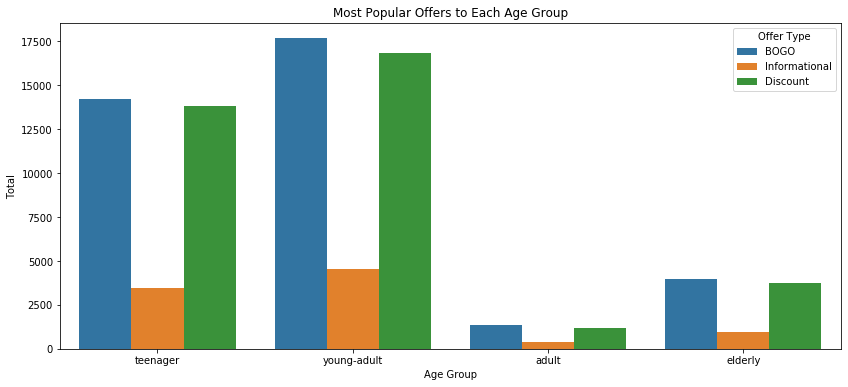

In [78]:
plt.figure(figsize=(14, 6))
g = sns.countplot(x="age_group", hue="offer_type", data=master_df)
plt.title('Most Popular Offers to Each Age Group')
plt.ylabel('Total')
plt.xlabel('Age Group')
xlabels = ['teenager','young-adult','adult','elderly']
g.set_xticklabels(xlabels)
plt.xticks(rotation = 0)
plt.legend(title='Offer Type')
plt.show();

The most common offer type among all age groups is the BOGO , followed by the Discount Offers. Whereas, the least common offer to be sent is the informational offers. I believe that BOGO offers are more attractive compared to other offers provided by Starbucks.

- 2. Based on the highest income range in males or females?

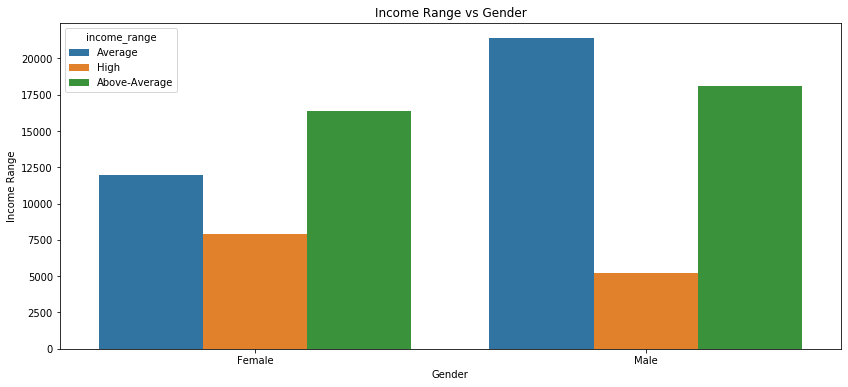

In [79]:
plt.figure(figsize=(14, 6))
g = sns.countplot(x="gender", hue="income_range", data= master_df[master_df["gender"] != 3])
plt.title('Income Range vs Gender')
plt.ylabel('Income Range')
xlabels = ['Female', 'Male']
g.set_xticklabels(xlabels)
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.show();

Customers with High income (Above 90,000) are mostly female customers. Whereas, Average Income(30,000 - 60,000) customers are mostly males.

- 3. How many new members join Starbucks App on each year?

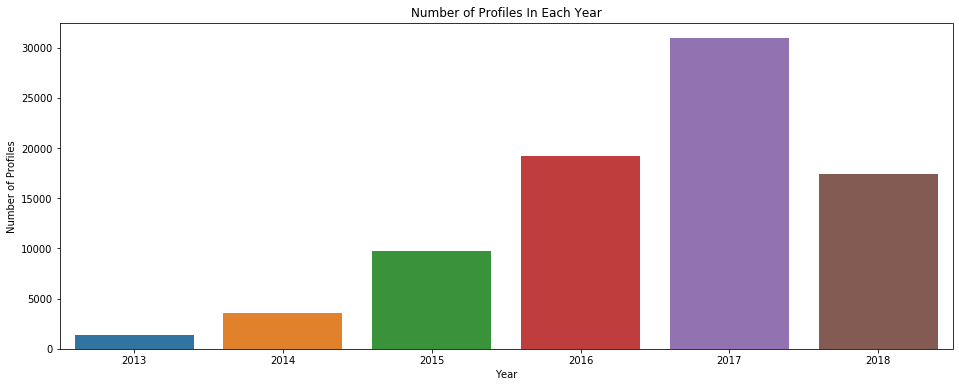

In [80]:
master_df['membership_year'] = master_df['membership_year'].astype(int)

plt.figure(figsize=(16, 6))
sns.countplot(master_df['membership_year'])
plt.title('Number of Profiles In Each Year')
plt.ylabel('Number of Profiles')
plt.xlabel('Year')
plt.xticks()
plt.show();

In [81]:
# getting the number of customers that became members on 2017
members_2017 = (master_df['membership_year']==2017).sum()

# getting the total number of members among all the available years
total = master_df['membership_year'].count()

# getting the percentages of customers that became members on 2017
perc_2017 = round((members_2017/total)*100,2)

print(members_2017)
perc_2017

30938


37.63

2017 was the best year for Starbucks in terms of the number of new members. Around %38 of all the customers on our dataset regiseterd as members on this specific year.

- 4. Which offers types each gender likes?

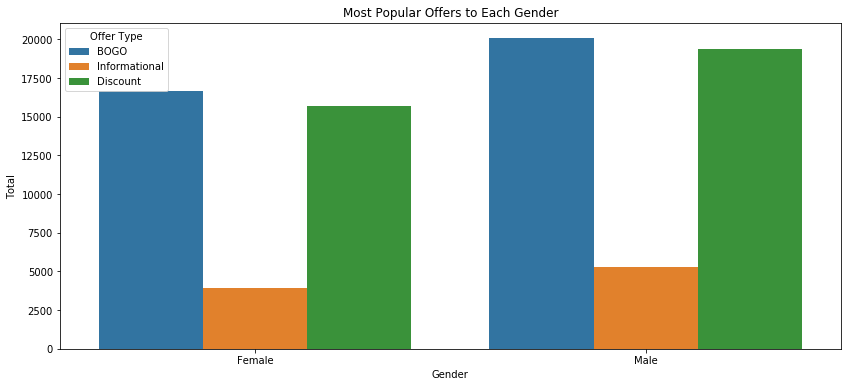

In [82]:
plt.figure(figsize=(14, 6))
g = sns.countplot(x='gender', hue="offer_type", data= master_df[master_df["gender"] != 3])
plt.title('Most Popular Offers to Each Gender')
plt.ylabel('Total')
plt.xlabel('Gender')
xlabels = ['Female', 'Male']
g.set_xticklabels(xlabels)
plt.legend(title='Offer Type')
plt.show();

The chart we got showed that both genders like BOGO and Discount offers and they have the same reaction toward Informational offers, they both seem to be not intersted to it.

- 5. What is the average time between two transcript for the same customer?

In [83]:
tran_avg_len = master_df.groupby(['customer_id', 'offer_id'])['time_h'].mean().reset_index()
tran_avg_len['time_h'].mean(), tran_avg_len['time_h'].mean() / 24

(372.2618460619763, 15.510910252582347)

The mean time it takes a customer to complete an offer is less than 16 days (372 hours).

- 6. How many offers are completed and customers viewed?

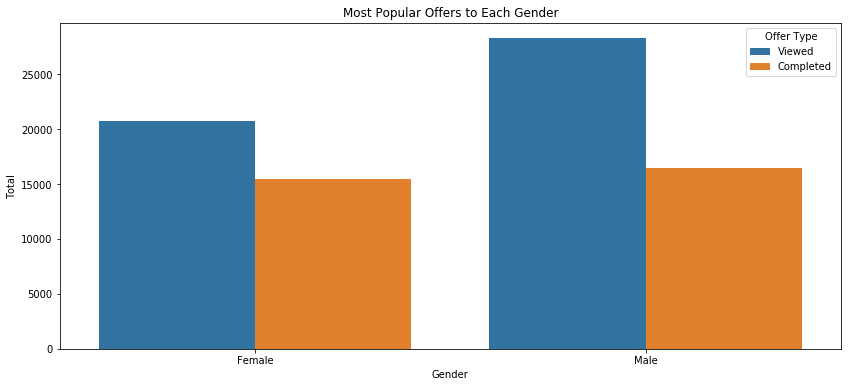

In [84]:
plt.figure(figsize=(14, 6))
g = sns.countplot(x='gender', hue="event", data= master_df[master_df["gender"] != 3])
plt.title('Most Popular Offers to Each Gender')
plt.ylabel('Total')
plt.xlabel('Gender')
xlabels = ['Female', 'Male']
g.set_xticklabels(xlabels)
plt.legend(title='Offer Type')
plt.show();

In [85]:
total_trans_g_o = master_df[master_df["gender"] != 3].groupby(['gender','offer_type']).count()
total_trans_g_e = master_df[master_df["gender"] != 3].groupby(['gender','event']).count()
total_trans_go_o_t = total_trans_g_o.loc[(1)]['event'].sum()
total_trans_go_o_tt = total_trans_g_o.loc[(2)]['event'].sum()
total_trans_go_o_t_offers_f = total_trans_g_o.loc[(1)].loc[['BOGO', 'Discount', 'Informational']]['event'].sum()
total_trans_go_o_t_offers_m = total_trans_g_o.loc[(2)].loc[['BOGO', 'Discount', 'Informational']]['event'].sum()

In [86]:
print('For Females:')
print(f"Number of offer completed: {total_trans_g_e.loc[(1, 'Completed')].values[0]}, {round((total_trans_g_e.loc[(1, 'Completed')].values[0]/total_trans_g_e.loc[(1, 'Viewed')].values[0])*100,2)}% of total offers viewed.")
print(f"Number of offer viewed: {total_trans_g_e.loc[(1, 'Viewed')].values[0]}.")

print('\nFor Males:')
print(f"Number of offer completed: {total_trans_g_e.loc[(2, 'Completed')].values[0]}, {round((total_trans_g_e.loc[(2, 'Completed')].values[0]/total_trans_g_e.loc[(2, 'Viewed')].values[0])*100,2)}% of total offers viewed.")
print(f"Number of offer viewed: {total_trans_g_e.loc[(2, 'Viewed')].values[0]}.")

For Females:
Number of offer completed: 15469, 74.47% of total offers viewed.
Number of offer viewed: 20771.

For Males:
Number of offer completed: 16439, 58.15% of total offers viewed.
Number of offer viewed: 28268.


Females completed around 75% of the offers they viewed, it is 16% more than males who just completed 58% of the offers they viewed. Feamles seems to be convinced by the promotion easier than males.

In [87]:
# Replacing the categorical values of the features by its corresponding numerical values, as before
labels_event1 = master_df['event'].astype('category').cat.categories.tolist()
replace_map_comp_event1 = {'event' : {k: v for k,v in zip(labels_event1,list(range(1,len(labels_event1)+1)))}}

labels_income1 = master_df['income_range'].astype('category').cat.categories.tolist()
replace_map_comp_income_range1 = {'income_range' : {k: v for k,v in zip(labels_income1,list(range(1,len(labels_income1)+1)))}}

labels_offer_type1 = master_df['offer_type'].astype('category').cat.categories.tolist()
replace_map_comp_offer_type1 = {'offer_type' : {k: v for k,v in zip(labels_offer_type1,list(range(1,len(labels_offer_type1)+1)))}}

master_df.replace(replace_map_comp_event1, inplace=True)
master_df.replace(replace_map_comp_offer_type1, inplace=True)
master_df.replace(replace_map_comp_income_range1, inplace=True)
master_df.replace(replace_map_comp_age_group, inplace=True)

In [88]:
# confirming changes
master_df.head()

,customer_id,event,time_h,offer_id,amount,reward_x,reward_y,difficulty,duration,offer_type,web,mobile,email,social,gender,age_group,income_range,membership_year,member_type
0,3729,2,0,9,0,0,0.5,0.25,5,1,1,1,1,1,2.0,4,2,2018,1.0
1,13995,2,0,6,0,0,0.0,0.00,3,3,0,1,1,1,3.0,3,2,2017,1.0
2,1052,2,0,5,0,0,1.0,0.50,5,1,1,1,1,1,1.0,4,2,2016,2.0
3,170,2,0,8,0,0,1.0,0.50,7,1,0,1,1,1,1.0,1,2,2016,2.0
4,12744,2,0,6,0,0,0.0,0.00,3,3,0,1,1,1,2.0,3,2,2014,3.0


In [89]:
master_df.to_csv('master_df.csv')

# - Modeling

In [90]:
master_df.columns

Index(['customer_id', 'event', 'time_h', 'offer_id', 'amount', 'reward_x',
       'reward_y', 'difficulty', 'duration', 'offer_type', 'web', 'mobile',
       'email', 'social', 'gender', 'age_group', 'income_range',
       'membership_year', 'member_type'],
      dtype='object')

**Features are as follows:**
    - time_h
    - offer_id
    - amount
    - reward_x ( Will be renamed to 'reward')
    - difficulty
    - duration_h
    - offer_type
    - gender
    - age_group
    - income_range
    - member_type

**Target is:**
    - 'event':
        - 1 : offer completed
        - 2 : offer viewed

In [91]:
# Rename 'reward_x' column to 'reward'
master_df.rename(columns ={'reward_x':'reward'}, inplace = True)

In [92]:
# Split the data into features and target label
X = master_df[['time_h','offer_id','amount','reward','difficulty','duration','offer_type','gender','age_group','income_range', 'member_type']]
Y = master_df['event']

In [93]:
X.head()

,time_h,offer_id,amount,reward,difficulty,duration,offer_type,gender,age_group,income_range,member_type
0,0,9,0,0,0.25,5,1,2.0,4,2,1.0
1,0,6,0,0,0.00,3,3,3.0,3,2,1.0
2,0,5,0,0,0.50,5,1,1.0,4,2,2.0
3,0,8,0,0,0.50,7,1,1.0,1,2,2.0
4,0,6,0,0,0.00,3,3,2.0,3,2,3.0


In [94]:
Y.head()

0    2
1    2
2    2
3    2
4    2
Name: event, dtype: int64

In [95]:
# normalizing some numerical values 
scaler = MinMaxScaler()
features = ['time_h', 'amount', 'reward', 'duration']
X_scaled = X.copy()
X_scaled[features] = scaler.fit_transform(X_scaled[features])
X_scaled.head()

,time_h,offer_id,amount,reward,difficulty,duration,offer_type,gender,age_group,income_range,member_type
0,0.0,9,0.0,0.0,0.25,0.285714,1,2.0,4,2,1.0
1,0.0,6,0.0,0.0,0.00,0.000000,3,3.0,3,2,1.0
2,0.0,5,0.0,0.0,0.50,0.285714,1,1.0,4,2,2.0
3,0.0,8,0.0,0.0,0.50,0.571429,1,1.0,1,2,2.0
4,0.0,6,0.0,0.0,0.00,0.000000,3,2.0,3,2,3.0


In [96]:
# creating training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

In [97]:
X_train.shape, X_test.shape

((61665, 11), (20556, 11))

In [98]:
y_train.shape, y_test.shape

((61665,), (20556,))

- from sklearn.preprocessing import MinMaxScaler
- from sklearn.model_selection import train_test_split, GridSearchCV
- from sklearn.tree import DecisionTreeClassifier
- from sklearn.naive_bayes import GaussianNB 
- from sklearn.neighbors import KNeighborsClassifier
- from sklearn.linear_model import LogisticRegression
- from sklearn.ensemble import RandomForestRegressor

In [99]:
# defining a function to calculate the accuracy for the models we will try below 
from sklearn.metrics import plot_roc_curve
def predict_score(model):
    pred = model.predict(X_test)
    
    # Calculate the absolute errors
    errors = abs(pred - y_test)
    
    # Calculate mean absolute percentage error
    mean_APE = 100 * (errors / y_test)
    accuracy = 100 - np.mean(mean_APE)
    
    return round(accuracy, 4)

**Decision Tree**

Accuracy of Decision Tree classifier on training set: 100.0%.
Prediction Accuracy: 100.0%


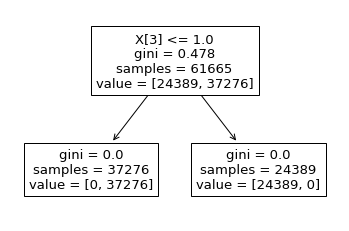

In [106]:
from sklearn import tree
dt = tree.DecisionTreeClassifier()

dt.fit(X_train, y_train)

tree.plot_tree(dt) 
print(f'Accuracy of Decision Tree classifier on training set: {round(dt.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {predict_score(dt)}%')

**Naive Bayes**

Accuracy of SVM classifier on training set: 100.0%.
Prediction Accuracy: 100.0%


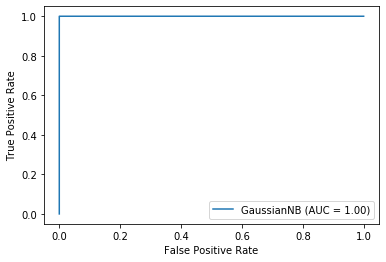

In [101]:
gnb = GaussianNB() 
gnb.fit(X_train, y_train) 
gnb_disp = plot_roc_curve(gnb, X_test, y_test)
print(f'Accuracy of SVM classifier on training set: {round(gnb.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {predict_score(gnb)}%')

**K-Nearest Neighbors**

Accuracy of K-NN classifier on training set: 99.95%.
Prediction Accuracy: 99.9538%


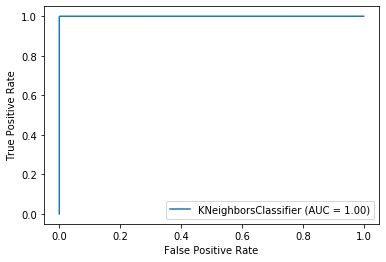

In [102]:
knn = KNeighborsClassifier()

knn.fit(X_train, y_train)
knn_disp = plot_roc_curve(knn, X_test, y_test)
print(f'Accuracy of K-NN classifier on training set: {round(knn.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {predict_score(knn)}%')

**LogisticRegression**

C:\Users\sahil\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy of Logistic regression classifier on training set: 100.0%.
Prediction Accuracy: 100.0%


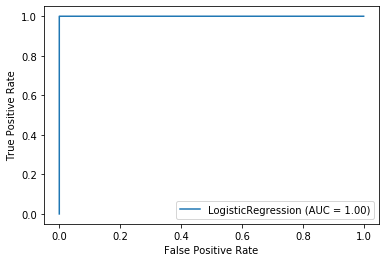

In [103]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)
logreg_disp = plot_roc_curve(logreg, X_test, y_test)
print(f'Accuracy of Logistic regression classifier on training set: {round(logreg.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {predict_score(logreg)}%')

**Random Forest**

In [104]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

rf.fit(X_train, y_train)

print(f'Accuracy of SVM classifier on training set: {round(rf.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {predict_score(rf)}%')

Accuracy of SVM classifier on training set: 100.0%.
Prediction Accuracy: 100.0%


**Support Vector Machine**

In [111]:
from sklearn import svm
svm = svm.SVC(gamma = 'auto')

svm.fit(X_train, y_train)
print(f'Accuracy of SVM classifier on training set: {round(svm.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {predict_score(svm)}%')

Accuracy of SVM classifier on training set: 100.0%.
Prediction Accuracy: 99.9927%


### Model Evaluation

In [112]:
# creating the variables that will be used to fill the results table
models = [svm, dt, gnb, knn, rf, logreg]
model_names = [type(n).__name__ for n in models]
training_accuracy = [x.score(X_train, y_train)*100 for x in models]
predection_accuracy = [predict_score(y) for y in models]

In [113]:
# structuring a table to view the results of the different model tried above
results = [training_accuracy, predection_accuracy]
results_df = pd.DataFrame(results, columns = model_names, index=['Training Accuracy', 'Predicting Accuracy']) 

In [114]:
# show the results dataframe 
results_df

,SVC,DecisionTreeClassifier,GaussianNB,KNeighborsClassifier,RandomForestRegressor,LogisticRegression
Training Accuracy,99.998378,100.0,100.0,99.948107,100.0,100.0
Predicting Accuracy,99.992700,100.0,100.0,99.953800,100.0,100.0


The above table, shows the accuracy score related with using different models of supervised learning. As presented on the table, we had 100% accuracy in both training and testing sets for 4 models ( out of 6). To avoid over fitting as much as possible, I will choose the model that gave me the lowest accuracy score on the testing set,which is the **KNeighborsClassifier**. On this model , I got 99.92% on testing set. I know that this is a very high score, but I the other scores are higher than that. I chose this model because I believe that is can be used on a  to solve a Binary outcome problem statement. On whther the customer will  view the offer ( just viewing) or he (complete the offer).

### Model Refinment

Althgough I believe on the saying  " There is always a room for Improvement", But I think that the **KNeighborsClassifier** model is giving me a really high score. Trying to improve such model will surely cause us to get into the fault of Overfitting. 
So, I will not suggest any improvement on this model since I believe that we don't need to try to get better results.

It worth nothing saying that I was planning to use the **GridSearchCV** to improve that model that I choose. That was the plan before getting hit by the Very High scores.

## Conclusion

**Through this project , I tried to analyze the datasets provided by Starbucks and then build a model that can predict whether a customer would complete the offer or just view it?** 

First, I have explored each dataset, visualize it to get an overall understanding on the data. This also included analyzing different aspects of the datasets. Then, I moved to the Preprocessing Part. Preprocessing Data was the task that took most of the time and effort. The dataset is a bit tricky and the data included required me to use my wrangling/ engineering and preprocessing skills to get the final clean version of the three datasets. The next step was to create some latent features that can improve the performance of the model. These featured were actually derived from orginal existing column but with less range of values and simple values to include within the data set.  Examples on that are the following:

    - 'age_group' feature derived from 'age' feature. I was ,then, replace the feature's categorical labels by a corresponding numerical label, as follows: 
            - 1 : teenager
            - 2 : young-adult
            - 3 : adult
            - 4 : elderly
        
    -  'income_range' feature derived from 'income' feature. that includes the income-range to which the customer's income belongs. Then, I replaced the 'income_range' categorical labels by corresponding numerical labels, as follows: 
        - 1 : average (30,000 - 60,000)
        - 2 : above-average (60,0001 - 90,000)
        - 3 : high (more than 90,000)

    - 'member_type' feature derived from 'became_member_on' feature.  Of course, the features categorical labels has been replaced by corresponding numerical labels, as follows: 
        - 1 : new (memebr since 1000 days or less)
        - 2 : regular (1001 - 1,600 days of membership)
        - 3 : loyal (more than 1,600 days of membership)

**The analysis on the datasets allowed me to get the following insights:** 
- Customers income ranges from 30,000 and 120,000 with most of the customers’ incomes fall between 50,000 and 75,0000.
- According to the available data, There are three ‘gender’ categories into which the customers falls in ( M, F and O).  Keeping in our mind the above observation that there are 2175 missing values, Male Customers (8484 men) are more than Female Customers(6129 women) with 57%  of customers are Males compared to 41% Females. However, there are 212 customers chose “O” as their gender.  
- The most common offer type among all age groups is the BOGO , followed by the Discount Offers. Whereas, the least common offer to be sent is the informational offers. I believe that BOGO offers are more attractive compared to other offers provided by Starbucks.
- Customers with High income (Above 90,000) are mostly female customers. Whereas, Average Income(30,000 - 60,000) customers are mostly males.
- Males and Females are pretty close when it comes to the time spent to complete an offer. Both males and females take about 17 days to da so.
- 2017 was the best year for Starbucks in terms of the number of new members. Around %38 of all the customers on our dataset regiseterd as members on this specific year.
- Both genders like BOGO and Discount offers and they have the same reaction toward Informational offers, they both seem to be not interested to it.
- The mean time it takes a customer to complete an offer is less than 16 days (372 hours).
- Females completed around 75% of the offers they viewed, it is 16% more than males who just completed 58% of the offers they viewed. Feamles seems to be convinced by the promotion easier than males.